In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.7 MB/s eta 0:00:00


In [121]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
import scipy.special
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.metrics import (r2_score, roc_auc_score, roc_curve, accuracy_score, f1_score,
                             mean_squared_error, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder

In [4]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

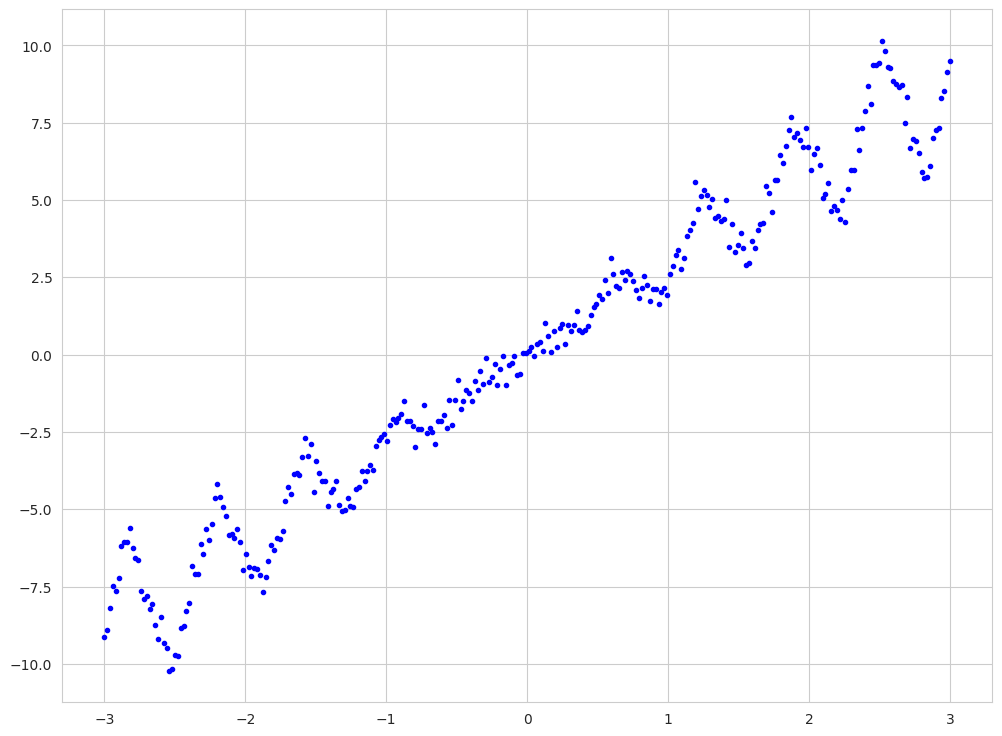

In [5]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [6]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

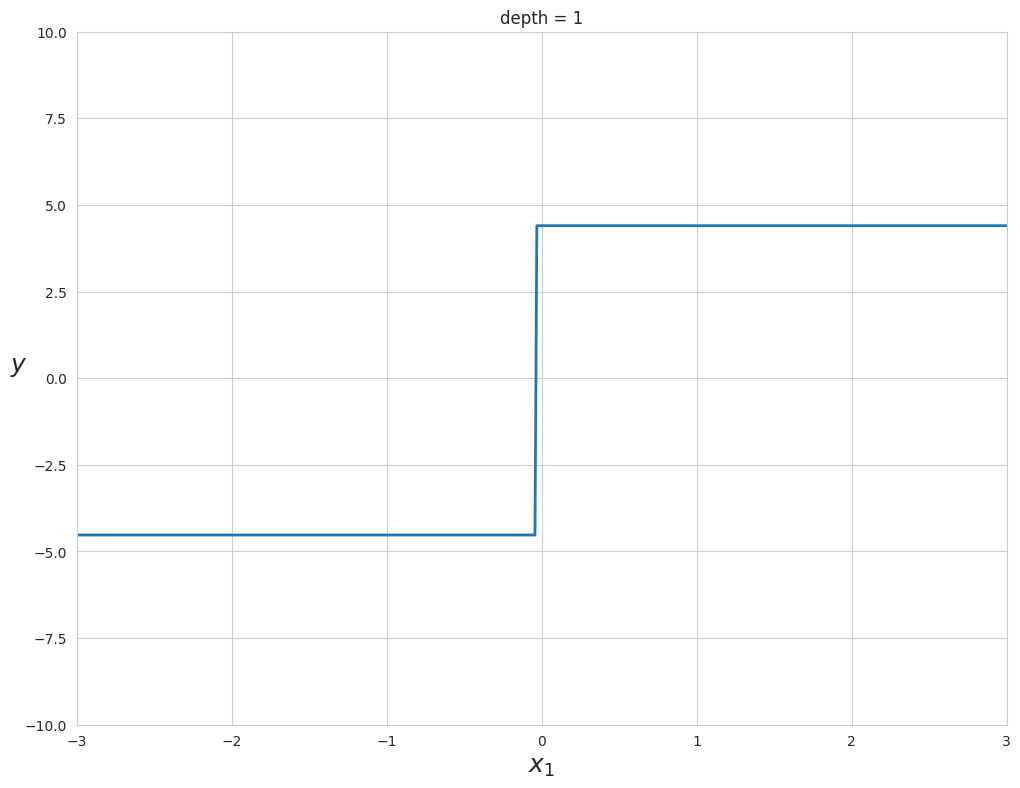

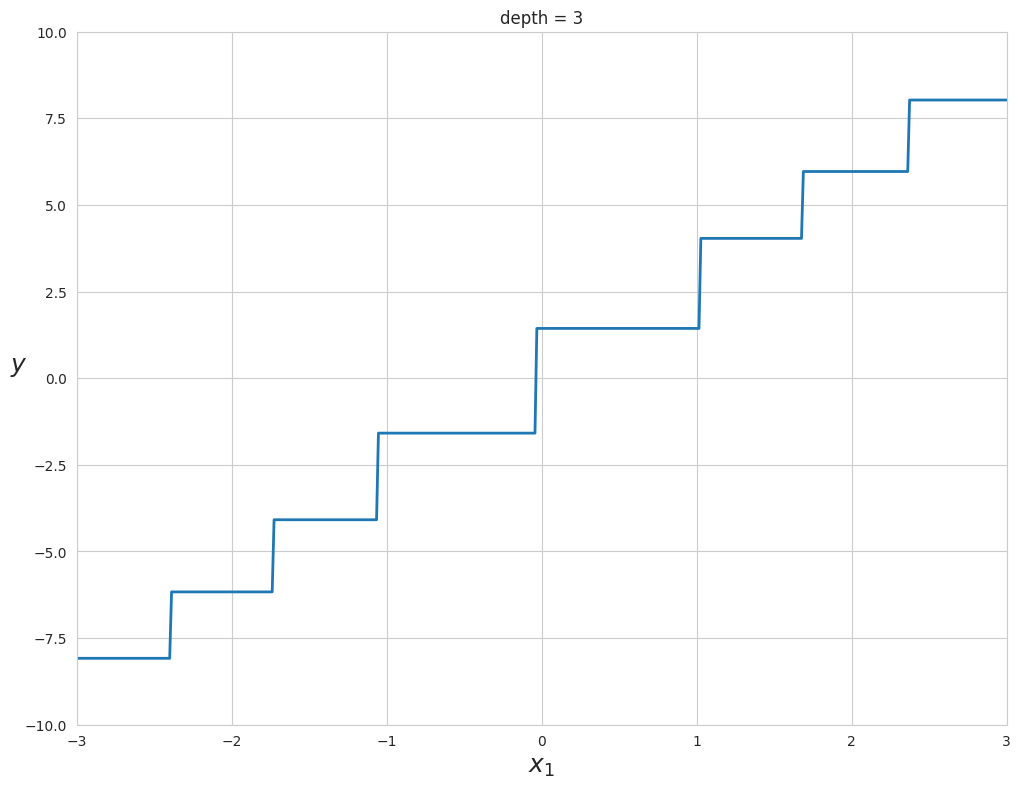

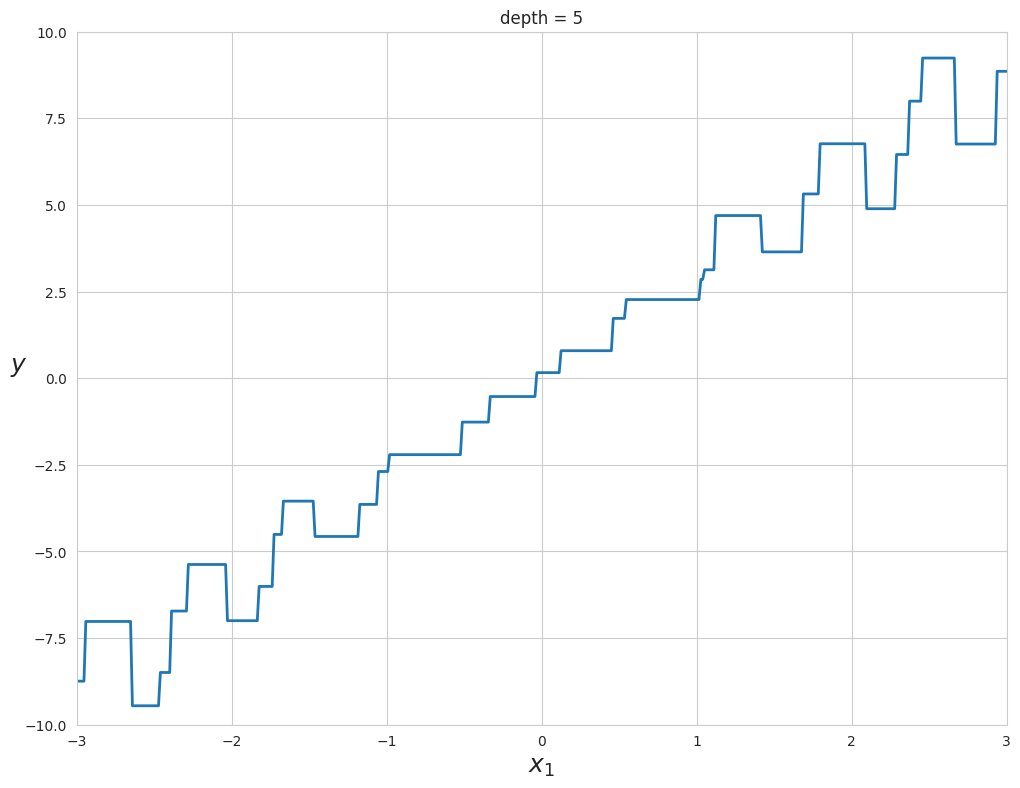

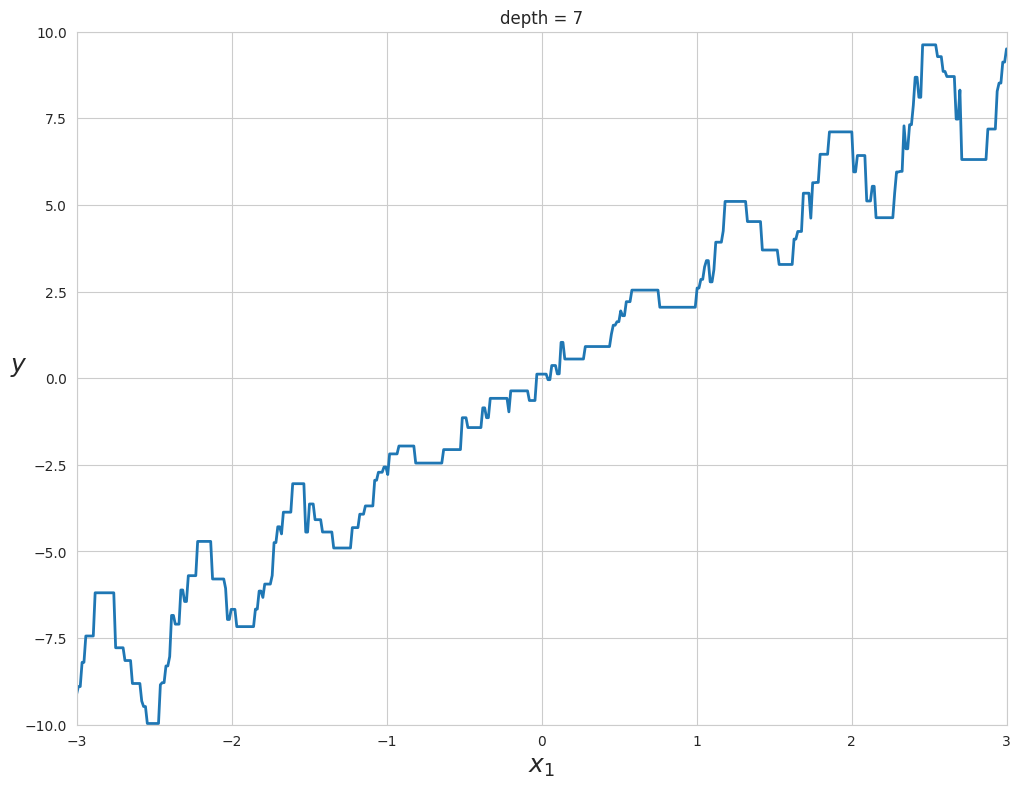

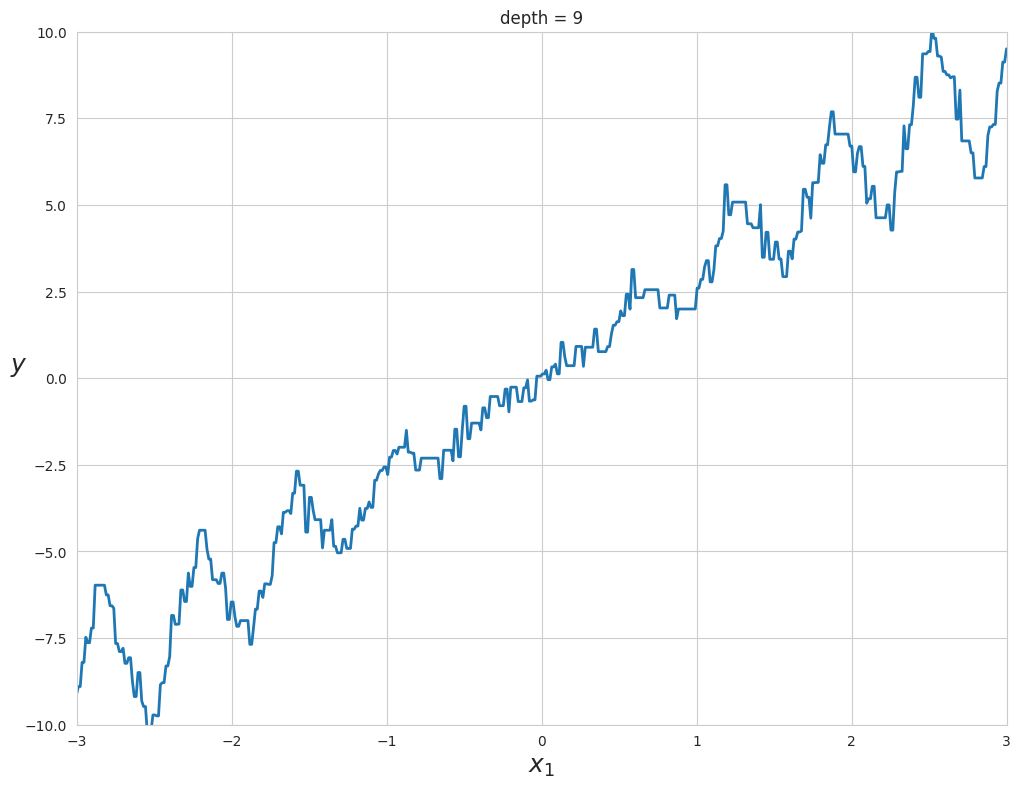

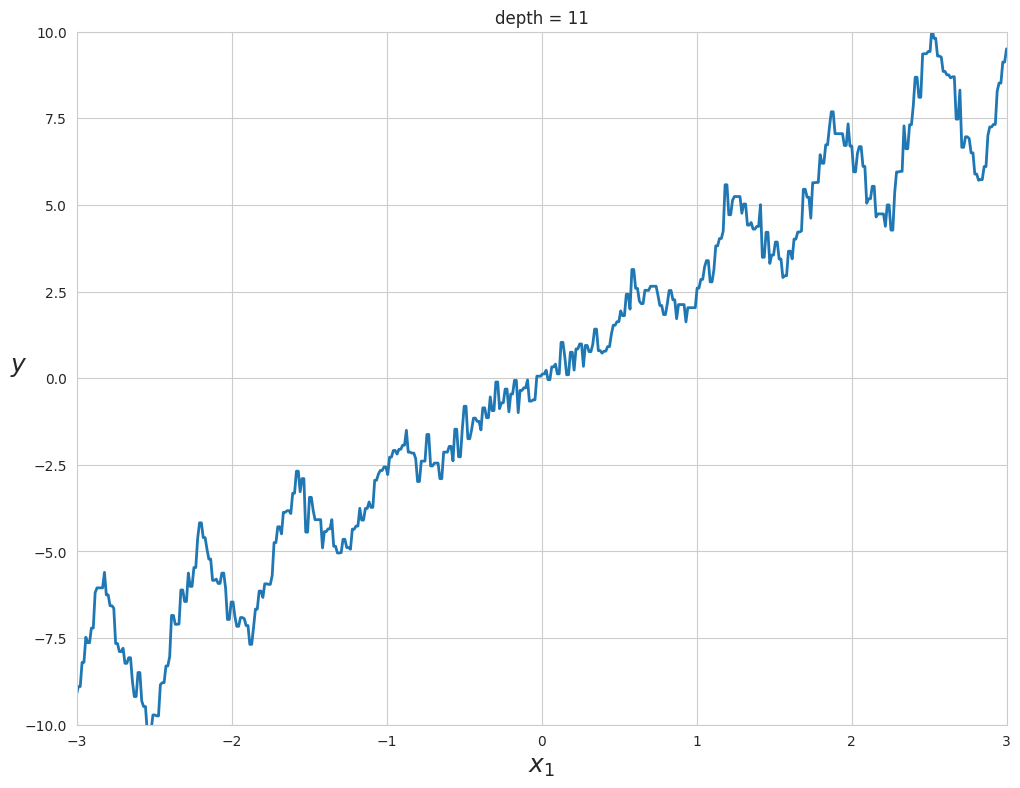

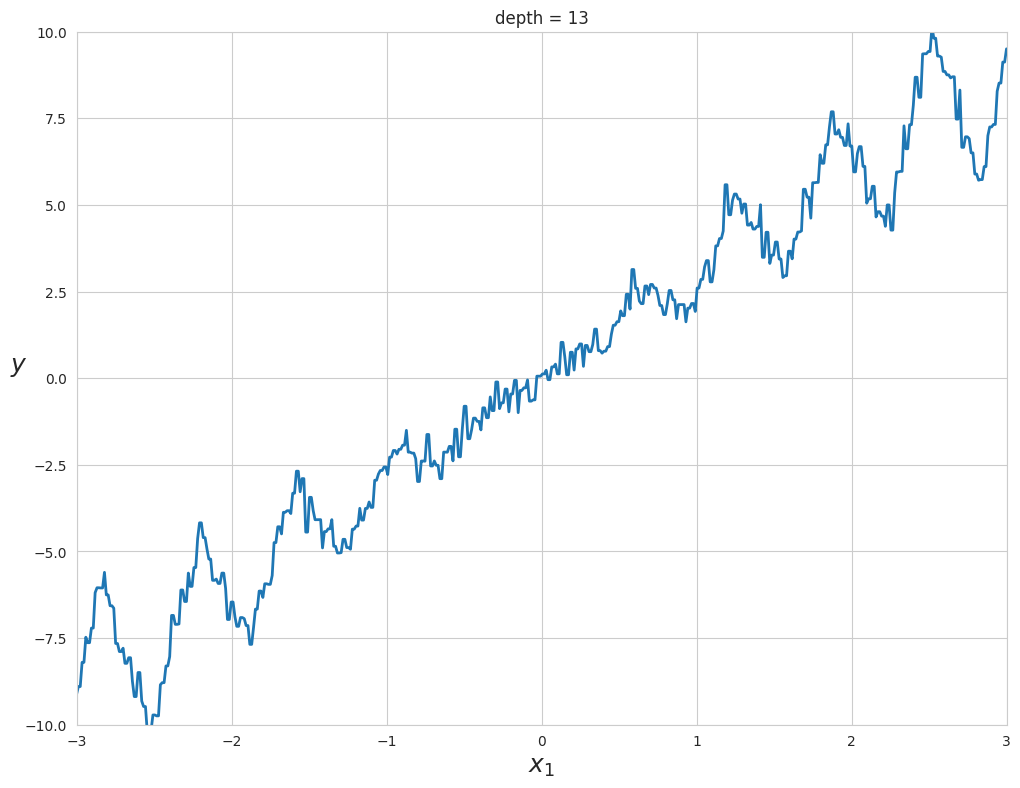

In [8]:
for depth in range (1, 15, 2):
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(X, y)
    plt.title(f'depth = {depth}')
    plot_regression_predictions(model, X, y)
    plt.show()

As we can see, the more depth we have the more precise predictions we can expect. However, models with very high depth can overfit to the trainnig data, having too specific predictors. Thus here depth of 7-9 might be the optimal one since there we have a general trand with main variability features, but without small fluctuations.

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [19]:
def majority_vote(n, p):
    return np.sum([scipy.special.comb(n, i) * (p**i) * (1-p)**(n-i) for i in range(math.floor(n/2) + 1, n + 1)])

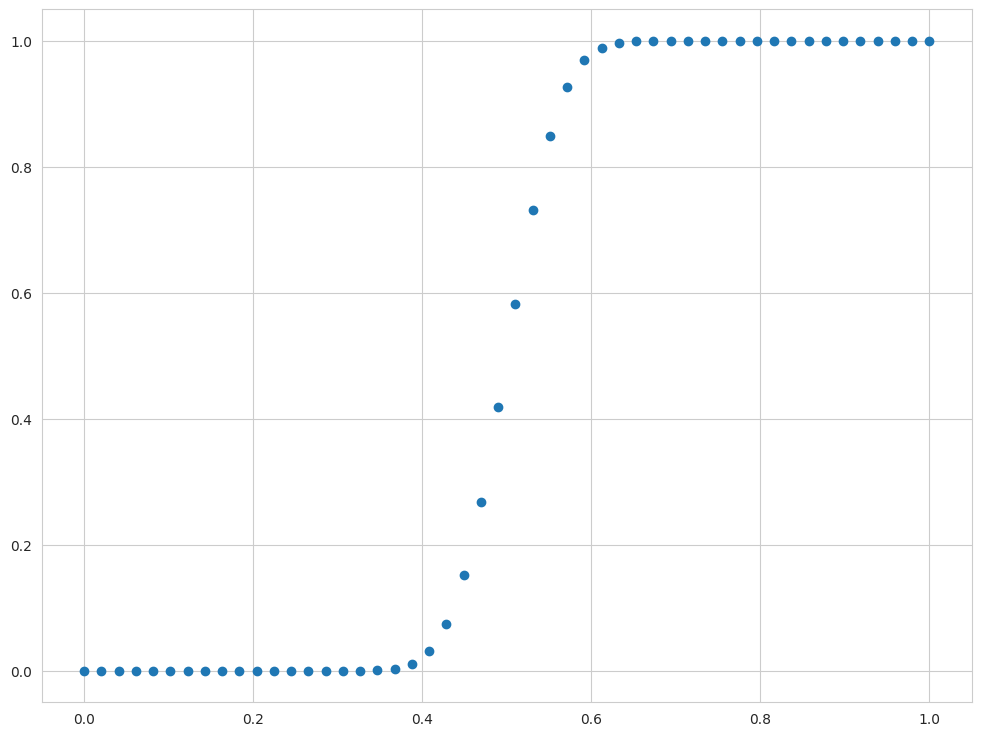

In [20]:
probs = np.linspace(0, 1, 50)
stats_res = [majority_vote(101, p) for p in probs]
plt.scatter(probs, stats_res)
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

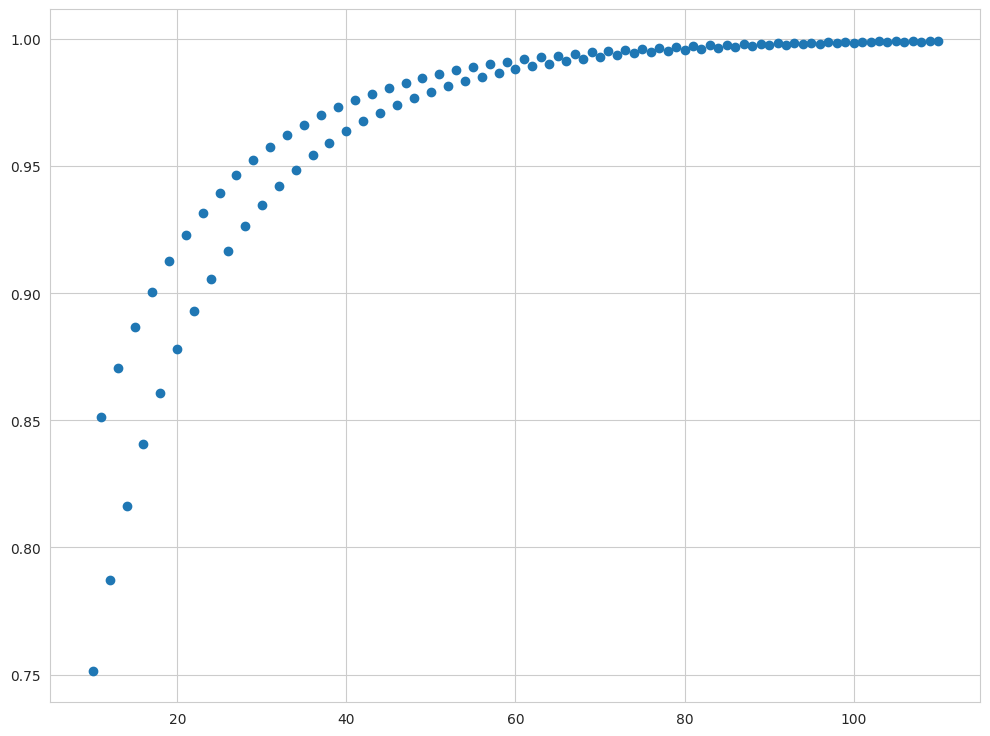

In [27]:
n_models = np.arange(10, 111, 1, dtype=int)
stat_res = [majority_vote(n, 0.65) for n in n_models]
plt.scatter(n_models, stat_res)
plt.show()

Опишите ваши наблюдения:

* Можно заметить, что форма кривых в этих двух случаях координально отличается - на первом графике мы видим, что на первом графике основной рост функции - при значениях $p$ от 0.4 до 0.6; до 0.4 вероятность близка к 0, после 0.6 - к 1.
* Соответственно, при 101 модели и вероятности $p$ для каждой модели, вероятность получить верный ответ в итоге oколо 1.
* С другой стороны, если мы посмотрим на второй график, мы заметим, что основной рост функции - в начале, до $n=60$. Ансамбли с четным числом моделей дают меньшую точность, нежели с нечетным - возможно, это связано с нижним порогом принятия решения, поскольку мы его занизили на единицу при использовании *math.floor*

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [28]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_features = X.shape[1]
        self.classes_ = sorted(np.unique(y))
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            indexes = np.arange(n_features, dtype=int)
            # selecting features
            self.feat_ids_by_tree.append(np.random.choice(indexes, self.max_features, replace=False))
            self.feat_ids_by_tree[-1] = np.array([self.feat_ids_by_tree[-1]]).reshape((1,))

            # bootstrap sample
            tmpIndexes = np.random.choice(np.arange(len(X), dtype=int), len(X), replace=True)
            tmpX = X[tmpIndexes] #:, self.feat_ids_by_tree[-1]]
            tmpX = tmpX[:, self.feat_ids_by_tree[-1]]
            tmpy = y[tmpIndexes]
            # defining a model
            model = DecisionTreeClassifier(max_depth=self.max_depth)
            model.fit(tmpX, tmpy)
            self.trees.append(model)

        return self

    def predict_proba(self, X):
        X = np.array(X)
        predicted_probs = []
        # collecting predictions from all models 
        for i in range(self.n_estimators):
            predicted_probs.append(self.trees[i].predict_proba(X[:, self.feat_ids_by_tree[i]]))
        return np.mean(predicted_probs, axis=0)
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [29]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

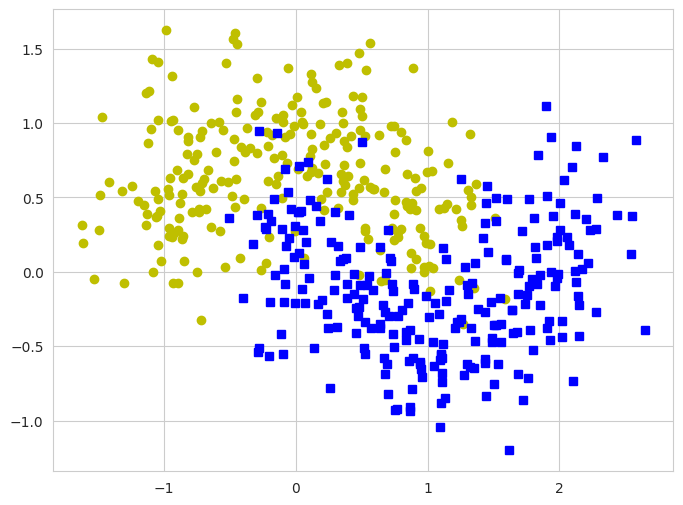

In [30]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

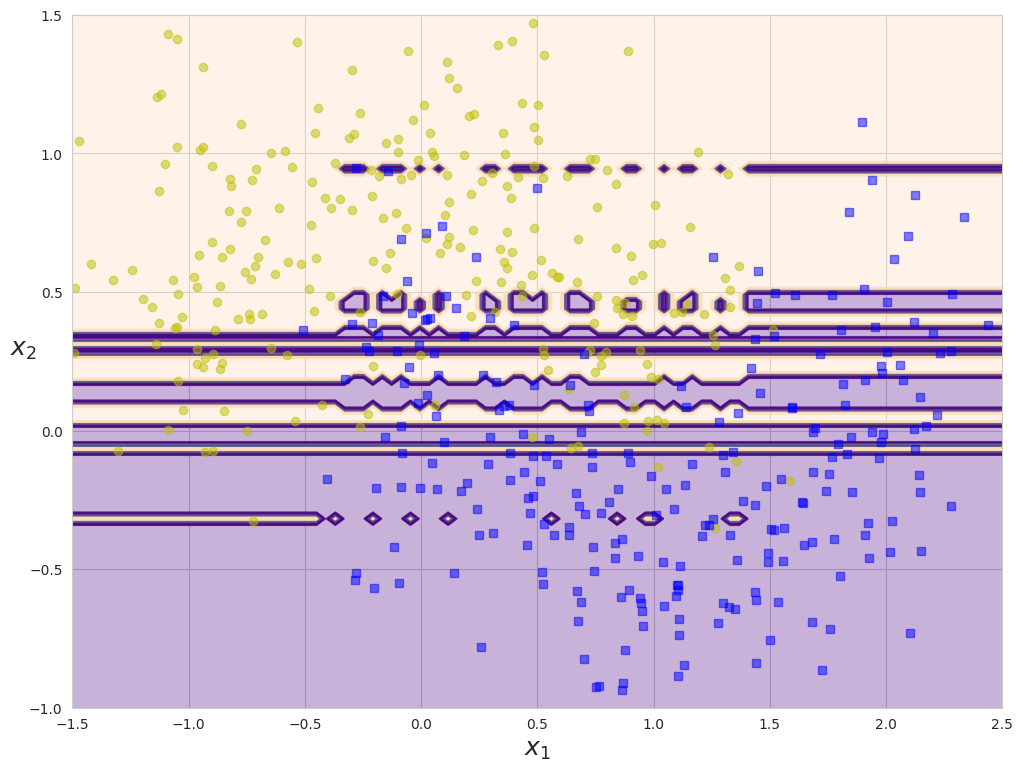

In [31]:
model = RandomForestClassifierCustom()
model.fit(X, y)
plot_decision_boundary(model, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True)

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

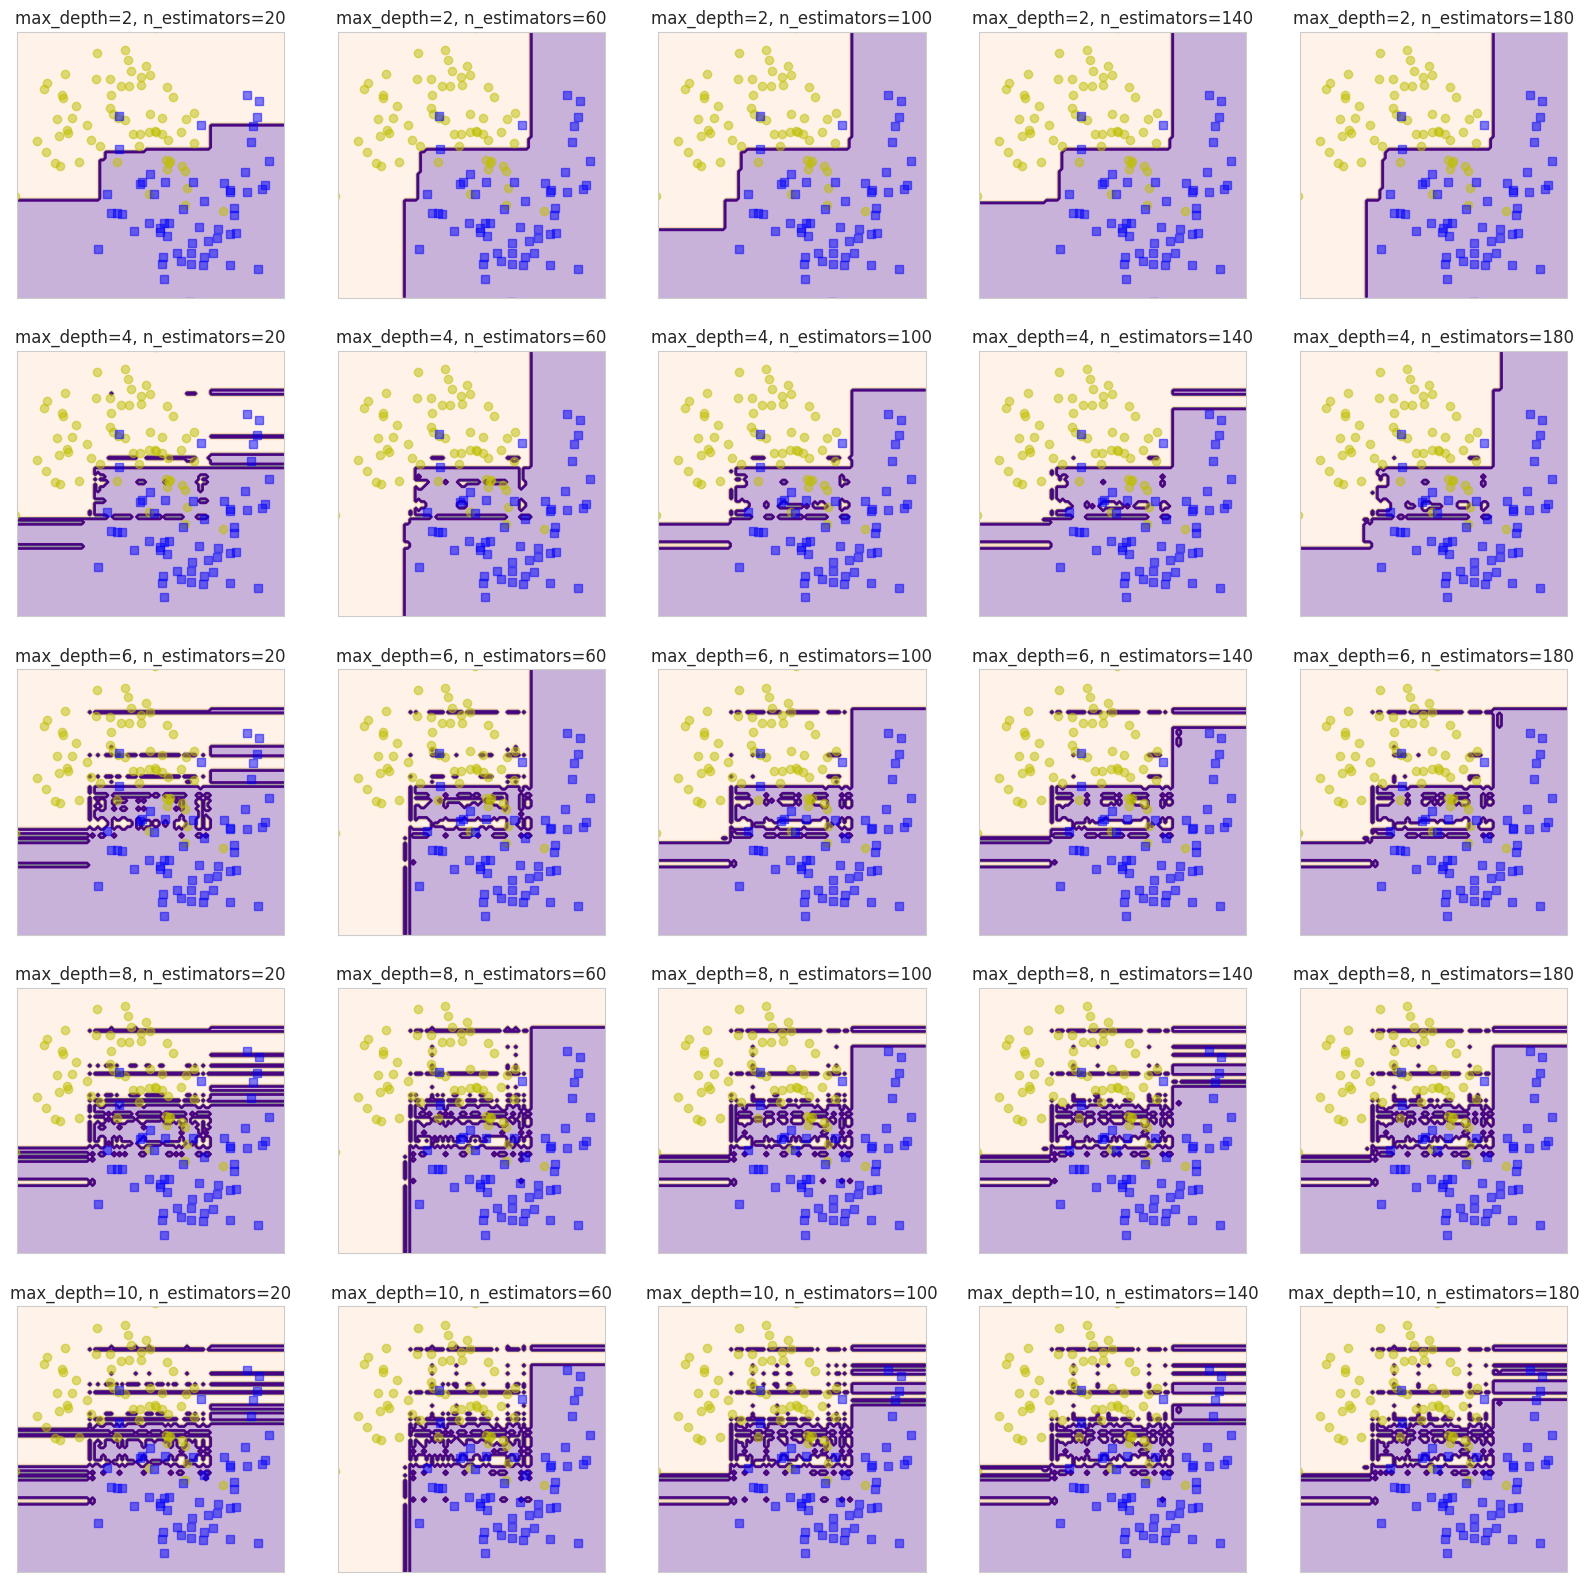

<Figure size 1000x1000 with 0 Axes>

In [54]:
plt.figure(figsize=(20, 20))
plot_ind = 1
for depth in range(2,11,2): # 5 values
    for n_estim in range(20, 200, 40): # 5 values
        my_ensamble = RandomForestClassifierCustom(max_depth=depth, n_estimators=n_estim)
        my_ensamble.fit(X_train,y_train)

        plt.subplot(5, 5, plot_ind)
        plot_decision_boundary(my_ensamble, X_test, y_test)
        plt.title(f'max_depth={depth}, n_estimators={n_estim}')

        plt.xlabel('')
        plt.ylabel('')
        plt.xticks([], [])
        plt.yticks([], [])
        plot_ind += 1

plt.figure(figsize=(10,10))
plt.show()

Самое адекватное разделение получилось при глубине 2 и 180 моделях.

Посмотрим теперь на то, что нашел grid search используя roc auc метрику:

In [55]:
param_grid = {'max_depth': range(1, 10, 2), 'n_estimators': range(20, 300, 30)}
model = RandomForestClassifierCustom()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1,
                    verbose=1, scoring='roc_auc')
grid.fit(X_train, y_train)
grid.best_score_, grid.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


(0.9446214550865714, {'max_depth': 3, 'n_estimators': 170})

На графике мы перебирали меньше различных вариантов, так что не удивительно что значения немного различаются. Тем не менее, можно утверждать, что глубина 2-3 и количество моделей около 170-180 будет давать наилучший результат.

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [56]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [57]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

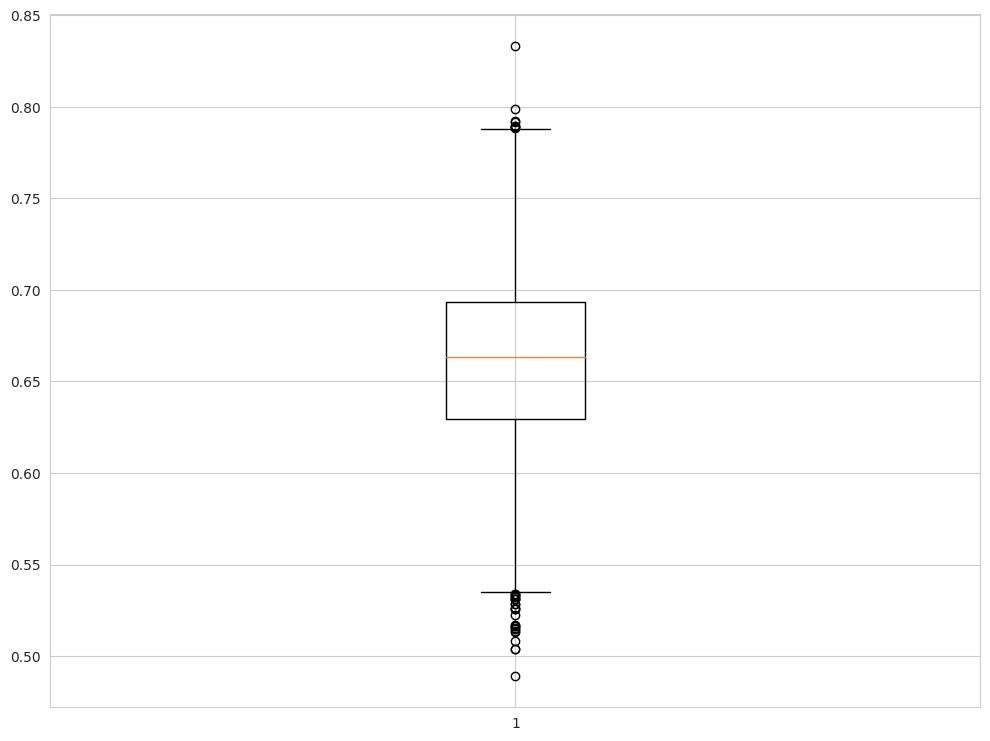

In [63]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
plt.boxplot(base_model_pair_correlation(model, X_train))
plt.show()

Попарная корреляция моделей при значениях по умолчанию находится в диапазоне от 0.5 до 0.85. 

Теперь давайте посмотрим, как на это влияет параметр `max_depth`: \\
(сверху в задании было написано про `max_features`.... - сделала и то, и то):

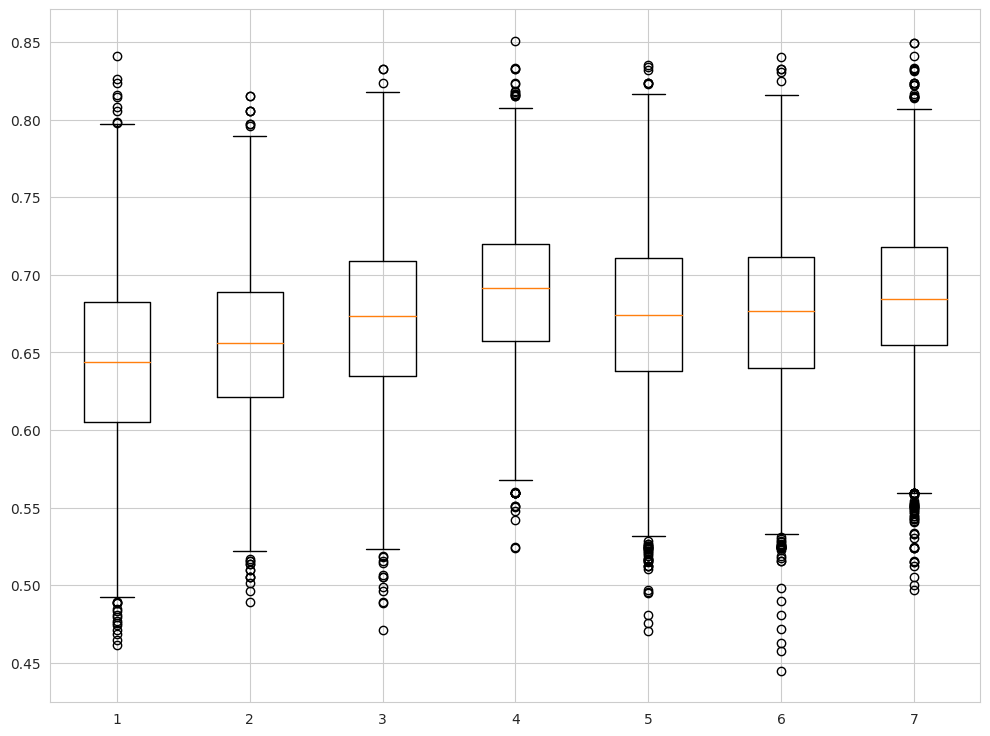

In [65]:
# Max features

values = []
for features in [1, 2, 5, 10, 20, 50, 100]:
    model = RandomForestClassifier(max_features=features)
    model.fit(X_train, y_train)
    values.append(base_model_pair_correlation(model, X_train))
plt.boxplot(values)
plt.show()

Можем видеть, что разброс попарной корреляции моделей почти не изменяется при изменении глубины, и остается в рамках 0.5-0.85 с медианой в районе 0.64-0.68.

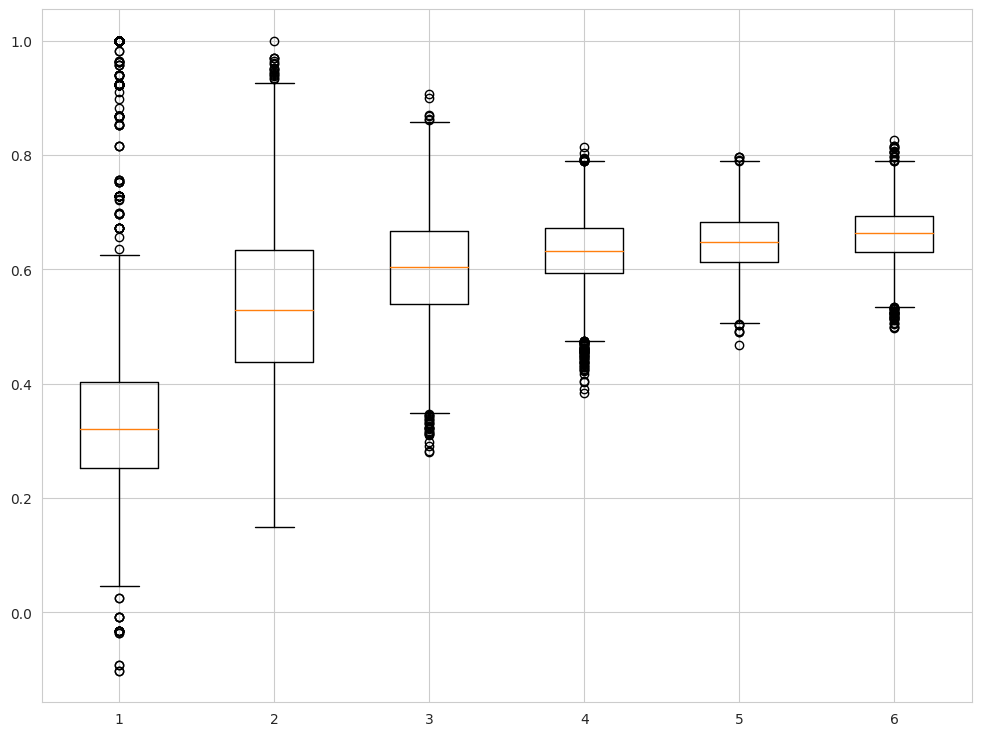

In [66]:
# Max depth

values = []
for depth in [1, 2, 3, 5, 10, 15]:
    model = RandomForestClassifier(max_depth=depth)
    model.fit(X_train, y_train)
    values.append(base_model_pair_correlation(model, X_train))
plt.boxplot(values)
plt.show()

Здесь же медианное значение корреляций растет с увеличением значения max_features, однако медианы все еще остаются в около 0.4-0.65. Важно отметить случай, когда у нас есть только один предиктор (max_features=1) - тогда медиана корреляций особенно низкая (~0.3) и значения варьируют от 0 до 1.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [5]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [6]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
178   43    1   0       120   177    0        0      120      1      2.5   
298   57    0   0       140   241    0        1      123      1      0.2   
201   60    1   0       125   258    0        0      141      1      2.8   
246   56    0   0       134   409    0        0      150      1      1.9   
153   66    0   2       146   278    0        0      152      0      0.0   

     slope  ca  thal  
178      1   0     3  
298      1   0     3  
201      1   1     3  
246      1   2     3  
153      1   1     2

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [31]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [32]:
voting_hard = VotingClassifier(base_models, voting='hard')
voting_soft = VotingClassifier(base_models, voting='soft')

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.820158269808819
LGBMClassifier: 0.8170106316447779
XGBRFClassifier: 0.8426829268292683
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [33]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [34]:
voting_soft = VotingClassifier(base_models, voting='soft')
voting_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('DT',
                              DecisionTreeClassifier(max_depth=10,
                                                     min_samples_leaf=10,
                                                     random_state=111)),
                             ('RF',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=111)),
                             ('ETC', ExtraTreesClassifier(random_state=111)),
                             ('KNN', KNeighborsClassifier(weights='distance')),
                             ('SVC_LIN',
                              SVC(kernel='linear', probability=True,
                                  random_state=111)),
                             ('SVC_RBF',
                              SV...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='binary:logistic',
                                              predictor=None, random_state=111,
                                              reg_alpha=None, ...)),
                             ('LR',
                              LogisticRegression(max_iter=10000,
                                                 solver='liblinear')),
                             ('NB', GaussianNB())],
                 voting='soft')

Очень классный красивый аутпут сверху! 😲

In [35]:
correlations = base_model_pair_correlation_for_voting_clf(voting_soft, X)

In [36]:
model_corr = {}
for modelA, modelB, corr in correlations:
    nameA = str(modelA)[:str(modelA).find('(')]
    nameB = str(modelB)[:str(modelB).find('(')]
    if 'catboost' in nameA:
        nameA = 'catboost'
    elif 'catboost' in nameB:
        nameB = 'catboost'
    model_corr[(nameA, nameB)] = corr

ser = pd.Series(list(model_corr.values()),
                  index=pd.MultiIndex.from_tuples(model_corr.keys()))
df = ser.unstack().fillna(0)
df

ExtraTreesClassifier  GaussianNB  \
DecisionTreeClassifier              0.793948    0.764327   
ExtraTreesClassifier                0.000000    0.720615   
KNeighborsClassifier                0.000000    0.631323   
LGBMClassifier                      0.000000    0.819441   
LogisticRegression                  0.000000    0.924957   
RandomForestClassifier              0.968670    0.803454   
SVC                                 0.000000    0.541284   
XGBClassifier                       0.000000    0.734594   
XGBRFClassifier                     0.000000    0.807158   
catboost                            0.000000    0.807685   

                        KNeighborsClassifier  LGBMClassifier  \
DecisionTreeClassifier              0.735671        0.908649   
ExtraTreesClassifier                0.940318        0.779951   
KNeighborsClassifier                0.000000        0.718994   
LGBMClassifier                      0.000000        0.848690   
LogisticRegression                  0.000000        0.000000   
RandomForestClassifier              0.914719        0.870749   
SVC                                 0.000000        0.548524   
XGBClassifier                       0.000000        0.000000   
XGBRFClassifier                     0.000000        0.000000   
catboost                            0.000000        0.872149   

                        LogisticRegression  RandomForestClassifier       SVC  \
DecisionTreeClassifier            0.836583                0.859324  0.504944   
ExtraTreesClassifier              0.761607                0.000000  0.436244   
KNeighborsClassifier              0.677738                0.000000  0.457342   
LGBMClassifier                    0.884577                0.000000  0.000000   
LogisticRegression                0.000000                0.000000  0.000000   
RandomForestClassifier            0.844085                0.000000  0.506063   
SVC                               0.574256                0.000000  0.534255   
XGBClassifier                     0.795470                0.000000  0.000000   
XGBRFClassifier                   0.873460                0.000000  0.000000   
catboost                          0.858331                0.000000  0.000000   

                        XGBClassifier  XGBRFClassifier  catboost  
DecisionTreeClassifier       0.831780         0.926360  0.859348  
ExtraTreesClassifier         0.970520         0.909525  0.968586  
KNeighborsClassifier         0.902434         0.846989  0.891877  
LGBMClassifier               0.816861         0.924415  0.000000  
LogisticRegression           0.000000         0.000000  0.000000  
RandomForestClassifier       0.968988         0.957060  0.983311  
SVC                          0.438351         0.516059  0.485431  
XGBClassifier                0.000000         0.945706  0.000000  
XGBRFClassifier              0.000000         0.000000  0.000000  
catboost                     0.978416         0.966242  0.000000

Посмотрим на то, какие модели с какими больше скоррелированы:

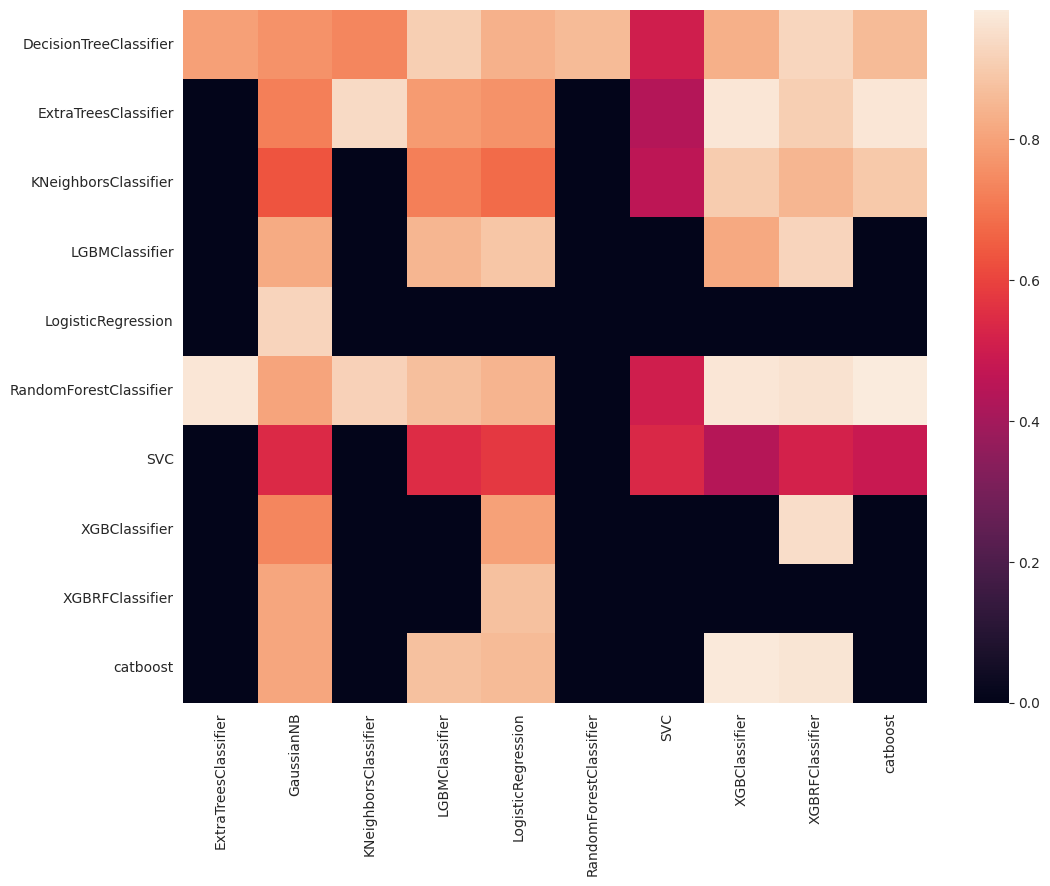

In [102]:
sns.heatmap(df);

Видно, что decision tree, random forest, XGBRF, GaussianNB много с какими моделями имеют высокие значения корреляции.  \\
Посчитаем общую сумму значений корреляций для каждой модели:

In [56]:
overall_sum = pd.DataFrame(df.sum(axis=1))
overall_sum.reset_index(inplace=True)
overall_sum.columns = ['model', 'corrs']

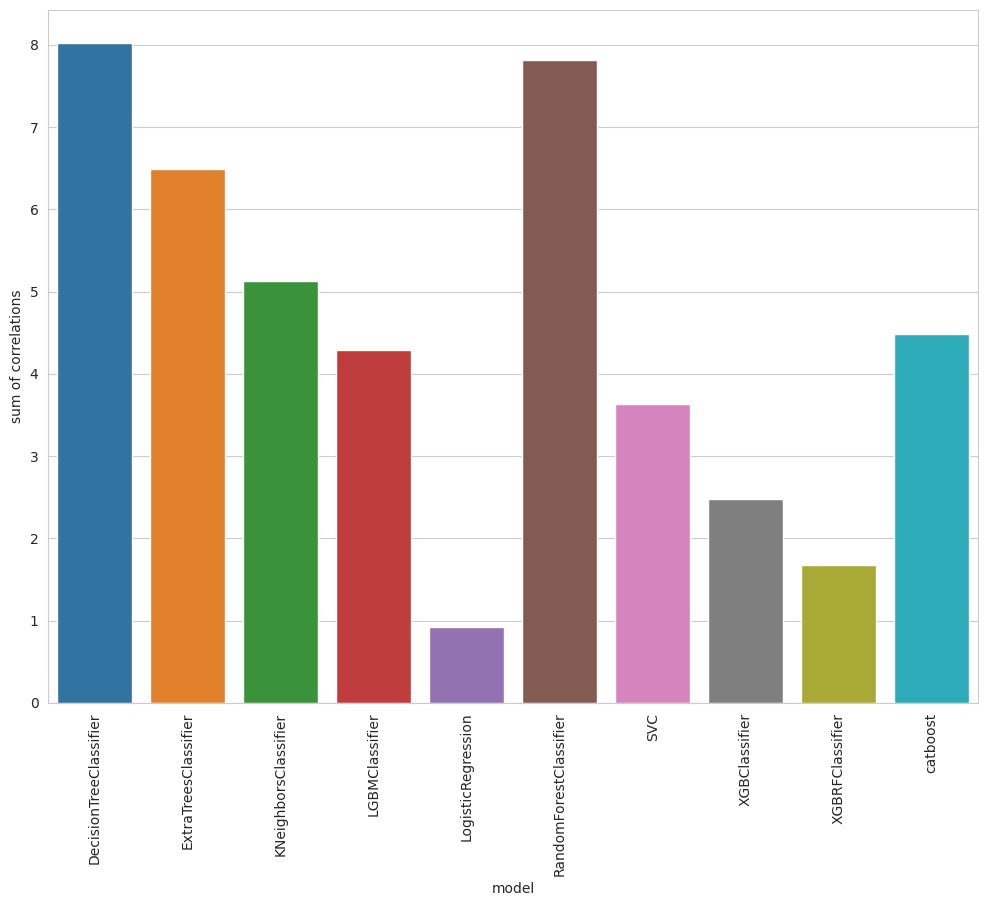

In [104]:
sns.barplot(overall_sum, y='sum of correlations', x='model')
plt.xticks(rotation=90)
plt.show()

Наиболее скоррелированные с другими моделями - decision tree и random forest, самая уникальная - логистическая регресия. В целом кажется логичным убираьт из ансамбля модели с похожим типом работы, поскольку они с высокой вероятностью будут давать очень похожие результаты. 

Для начала попробуем повыкидывать модели по-одной в зависимости от наибольшей суммы корреляций:

In [15]:
b = base_models.copy()
b[0]

('DT',
 DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111))

In [17]:
# Посмотрим на качество просто без DT:

b_wo_dt = b[1:]

voting_hard = VotingClassifier(estimators=b_wo_dt, voting='hard')
voting_soft = VotingClassifier(estimators=b_wo_dt, voting='soft')

scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1")
scores_soft = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print('Without Decision Tree:')
print('Hard:', scores_hard.mean())
print('Soft:', scores_soft.mean())

Without Decision Tree:
Hard: 0.8396418396418396
Soft: 0.8441585514756248


In [77]:
def max_corr(ensamble, X):
    correlations = base_model_pair_correlation_for_voting_clf(ensamble, X)
    model_corr = {}
    for modelA, modelB, corr in correlations:
        nameA = str(modelA)[:str(modelA).find('(')]
        nameB = str(modelB)[:str(modelB).find('(')]
        if 'catboost' in nameA:
            nameA = 'catboost'
        elif 'catboost' in nameB:
            nameB = 'catboost'
        model_corr[(nameA, nameB)] = corr

    ser = pd.Series(list(model_corr.values()),
                    index=pd.MultiIndex.from_tuples(model_corr.keys()))
    df = ser.unstack().fillna(0)
    overall_sum = pd.DataFrame(df.sum(axis=1))
    overall_sum.reset_index(inplace=True)
    overall_sum.columns = ['model', 'corrs']
    print(overall_sum[overall_sum['corrs'] == overall_sum['corrs'].max()])
    return

In [69]:
def scores_print(models, m):
    voting_hard = VotingClassifier(estimators=models, voting='hard')
    voting_soft = VotingClassifier(estimators=models, voting='soft')

    scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1")
    scores_soft = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
    print('\nWithout', str(m[1])[:str(m[1]).find('(')])
    print('Hard:', scores_hard.mean())
    print('Soft:', scores_soft.mean())
    voting_soft.fit(X_train, y_train)
    print('Max correlated:')
    max_corr(voting_soft, X_train)
    return

In [63]:
base_models = [("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

In [78]:
# Попробуем в дополнение к этому повыкидывать другие модели:

for m in [("RF", rf), ("KNN", knn), ("ETC", etc), ("XGB_RF", xgb_rf), ("XGB", xgb),
          ("CAT", cat), ("LGBM", lgbm)]:
    b = base_models.copy()
    b.remove(m)
    scores_print(b, m)


Without RandomForestClassifier
Hard: 0.8396418396418396
Soft: 0.8441585514756248
Max correlated:
                  model     corrs
0  ExtraTreesClassifier  6.566276

Without KNeighborsClassifier
Hard: 0.8360284701748117
Soft: 0.841005209328766
Max correlated:
                    model     corrs
3  RandomForestClassifier  6.954879

Without ExtraTreesClassifier
Hard: 0.8360284701748117
Soft: 0.8405342983656237
Max correlated:
                    model     corrs
3  RandomForestClassifier  6.954879

Without XGBRFClassifier
Hard: 0.8396418396418396
Soft: 0.8406964720641782
Max correlated:
                    model     corrs
4  RandomForestClassifier  6.966422

Without XGBClassifier
Hard: 0.8396418396418396
Soft: 0.8488270855559236
Max correlated:
                    model     corrs
4  RandomForestClassifier  6.945552

Without <catboost.core.CatBoostClassifier object at 0x7f8fdc3f3cd0
Hard: 0.8396418396418396
Soft: 0.8441585514756248
Max correlated:
                    model     corrs
4  Ra

In [79]:
# Качество везде примерно одинаковое, но везде Random forest сильно
# скоррелирован с другими моделями --> попробуем без него

base_models = [("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]
    
for m in base_models:
    b = base_models.copy()
    b.remove(m)
    scores_print(b, m)


Without ExtraTreesClassifier
Hard: 0.846897546897547
Soft: 0.8370722189541772
Max correlated:
                  model     corrs
0  KNeighborsClassifier  5.566276

Without KNeighborsClassifier
Hard: 0.8417969564311027
Soft: 0.833068701392258
Max correlated:
                  model     corrs
0  ExtraTreesClassifier  5.566276

Without SVC
Hard: 0.8500904201601728
Soft: 0.8477105550276282
Max correlated:
                  model     corrs
0  ExtraTreesClassifier  6.566276

Without SVC
Hard: 0.8489944373127942
Soft: 0.8407300086421635
Max correlated:
                  model     corrs
0  ExtraTreesClassifier  6.844699

Without <catboost.core.CatBoostClassifier object at 0x7f8fdc3f3cd0
Hard: 0.8452907336090906
Soft: 0.8488270855559236
Max correlated:
                  model     corrs
0  ExtraTreesClassifier  5.589218
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 

In [80]:
# Та же саамая ситуация - дропнем ETC в этот раз:

base_models = [("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]
    
for m in base_models:
    b = base_models.copy()
    b.remove(m)
    scores_print(b, m)


Without KNeighborsClassifier
Hard: 0.8539876113046846
Soft: 0.8455110375195781
Max correlated:
      model     corrs
5  catboost  4.485516

Without SVC
Hard: 0.8396418396418396
Soft: 0.8405342983656237
Max correlated:
                  model     corrs
0  KNeighborsClassifier  5.566276

Without SVC
Hard: 0.8527055600226333
Soft: 0.8455110375195781
Max correlated:
                  model     corrs
0  KNeighborsClassifier  5.844699

Without <catboost.core.CatBoostClassifier object at 0x7f8fdc3f3cd0
Hard: 0.8508130081300812
Soft: 0.8452028324459224
Max correlated:
                  model     corrs
0  KNeighborsClassifier  4.589218
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] b

Аналогичным образом выкидываю по одной модели --> подбираем на рандоме 👍. \\
В итоге лучшие скоры показали такие комбинации:

In [88]:
base_models = [("CAT", cat), ("NB", nb), ("SVC_RBF", svc_rbf)]
    
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

voting_hard.fit(X_train, y_train)
voting_soft.fit(X_train, y_train)

y_pred_hard = voting_hard.predict(X_test)
y_pred_soft = voting_soft.predict(X_test)

print(f1_score(y_test, y_pred_hard))

0.8712871287128713


In [87]:
base_models = [('RF', rf), ("LGBM", lgbm), ("LR", lr), ("NB", nb)]
    
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

voting_hard.fit(X_train, y_train)
voting_soft.fit(X_train, y_train)

y_pred_hard = voting_hard.predict(X_test)
y_pred_soft = voting_soft.predict(X_test)

print(f1_score(y_test, y_pred_hard))

0.9072164948453608


### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

#### Data prep

In [93]:
data = pd.read_csv("churn.csv")
data.head()

State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    KS             128        415  382-4657         no        yes   
1    OH             107        415  371-7191         no        yes   
2    NJ             137        415  358-1921         no         no   
3    OH              84        408  375-9999        yes         no   
4    OK              75        415  330-6626        yes         no   

   VMail Message  Day Mins  Day Calls  Day Charge  ...  Eve Calls  Eve Charge  \
0             25     265.1        110       45.07  ...         99       16.78   
1             26     161.6        123       27.47  ...        103       16.62   
2              0     243.4        114       41.38  ...        110       10.30   
3              0     299.4         71       50.90  ...         88        5.26   
4              0     166.7        113       28.34  ...        122       12.61   

   Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
0       244.7           91         11.01       10.0           3         2.70   
1       254.4          103         11.45       13.7           3         3.70   
2       162.6          104          7.32       12.2           5         3.29   
3       196.9           89          8.86        6.6           7         1.78   
4       186.9          121          8.41       10.1           3         2.73   

   CustServ Calls  Churn?  
0               1  False.  
1               1  False.  
2               0  False.  
3               2  False.  
4               3  False.  

[5 rows x 21 columns]

In [94]:
data.describe()

Account Length    Area Code  VMail Message     Day Mins    Day Calls  \
count     3333.000000  3333.000000    3333.000000  3333.000000  3333.000000   
mean       101.064806   437.182418       8.099010   179.775098   100.435644   
std         39.822106    42.371290      13.688365    54.467389    20.069084   
min          1.000000   408.000000       0.000000     0.000000     0.000000   
25%         74.000000   408.000000       0.000000   143.700000    87.000000   
50%        101.000000   415.000000       0.000000   179.400000   101.000000   
75%        127.000000   510.000000      20.000000   216.400000   114.000000   
max        243.000000   510.000000      51.000000   350.800000   165.000000   

        Day Charge     Eve Mins    Eve Calls   Eve Charge   Night Mins  \
count  3333.000000  3333.000000  3333.000000  3333.000000  3333.000000   
mean     30.562307   200.980348   100.114311    17.083540   200.872037   
std       9.259435    50.713844    19.922625     4.310668    50.573847   
min       0.000000     0.000000     0.000000     0.000000    23.200000   
25%      24.430000   166.600000    87.000000    14.160000   167.000000   
50%      30.500000   201.400000   100.000000    17.120000   201.200000   
75%      36.790000   235.300000   114.000000    20.000000   235.300000   
max      59.640000   363.700000   170.000000    30.910000   395.000000   

       Night Calls  Night Charge    Intl Mins   Intl Calls  Intl Charge  \
count  3333.000000   3333.000000  3333.000000  3333.000000  3333.000000   
mean    100.107711      9.039325    10.237294     4.479448     2.764581   
std      19.568609      2.275873     2.791840     2.461214     0.753773   
min      33.000000      1.040000     0.000000     0.000000     0.000000   
25%      87.000000      7.520000     8.500000     3.000000     2.300000   
50%     100.000000      9.050000    10.300000     4.000000     2.780000   
75%     113.000000     10.590000    12.100000     6.000000     3.270000   
max     175.000000     17.770000    20.000000    20.000000     5.400000   

       CustServ Calls  
count     3333.000000  
mean         1.562856  
std          1.315491  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          2.000000  
max          9.000000

In [96]:
data.isna().sum()

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

In [97]:
data.dtypes

State              object
Account Length      int64
Area Code           int64
Phone              object
Int'l Plan         object
VMail Plan         object
VMail Message       int64
Day Mins          float64
Day Calls           int64
Day Charge        float64
Eve Mins          float64
Eve Calls           int64
Eve Charge        float64
Night Mins        float64
Night Calls         int64
Night Charge      float64
Intl Mins         float64
Intl Calls          int64
Intl Charge       float64
CustServ Calls      int64
Churn?             object
dtype: object

Посмотрим на распределения параметров:

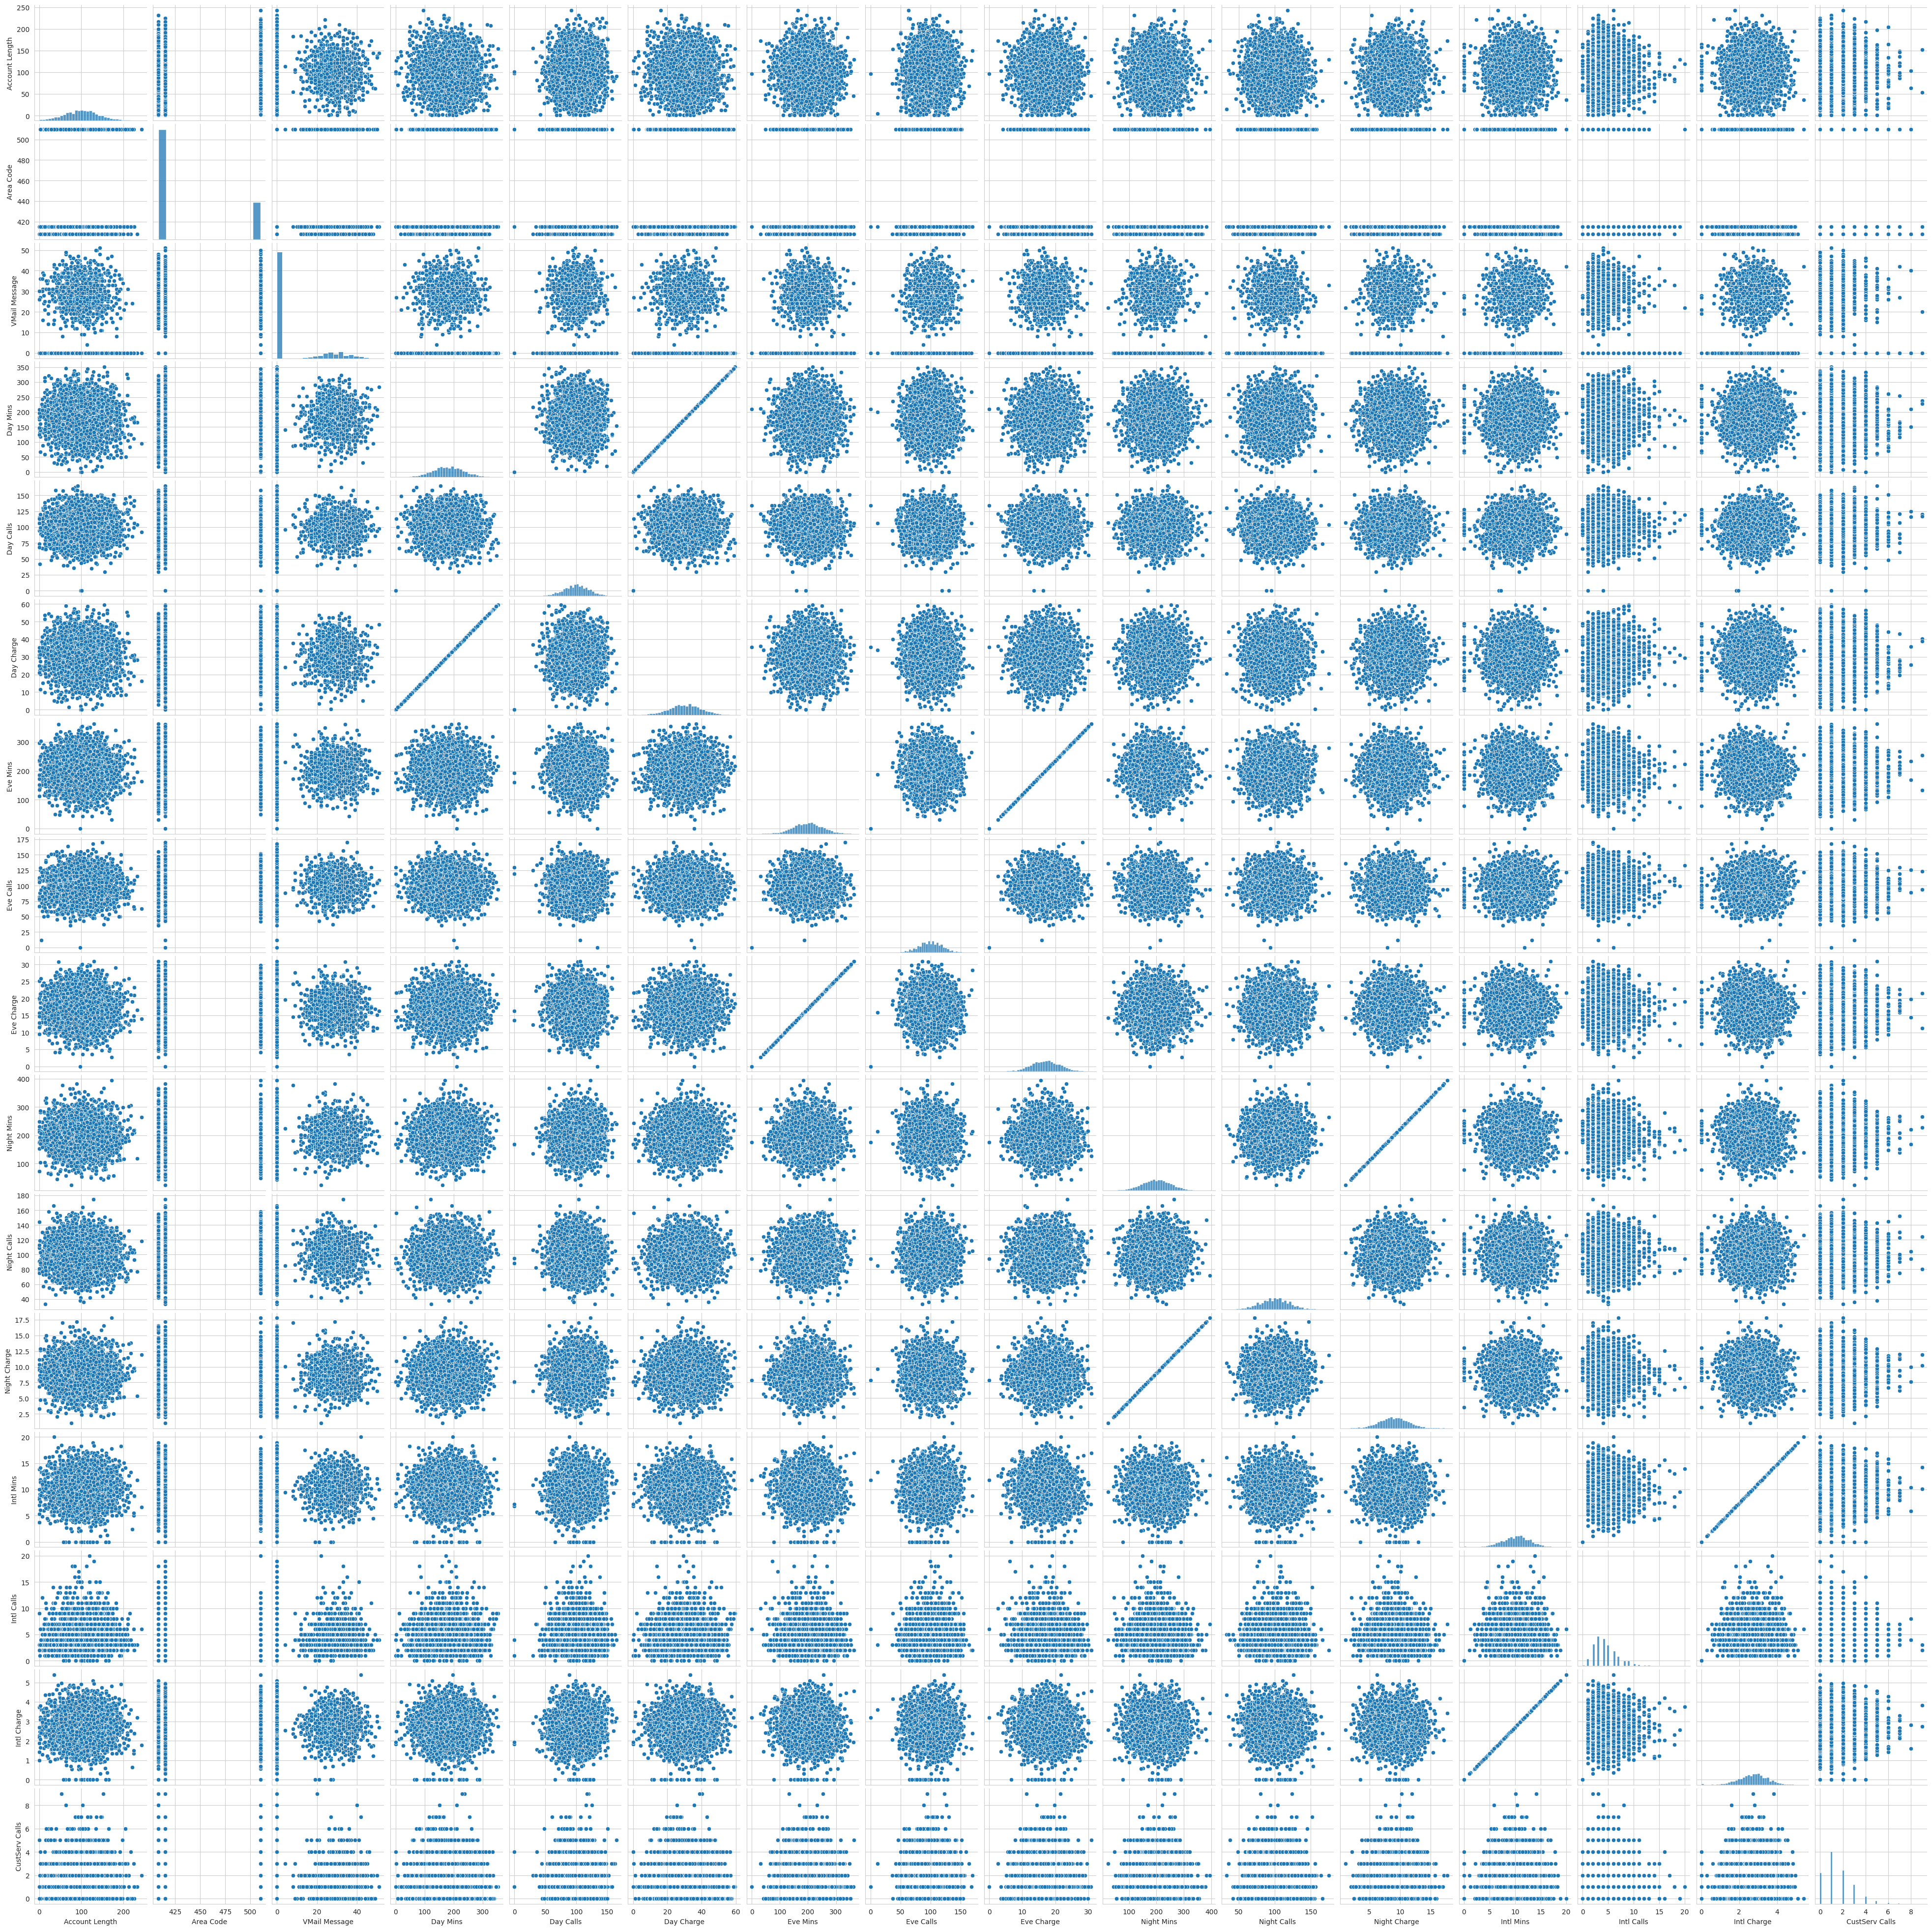

In [98]:
sns.pairplot(data);

Видно, что второй столбец имеет только три типа значений - переведем в object. Кроме того есть ряд линейных зависимостей: 4&6, 7&9, 10&12, 13&15 (mins & charge) --> оставим по одному призаку из них (mins).

In [101]:
data['Area Code'] = data['Area Code'].astype('object')

In [103]:
data.columns

Index(['State', 'Account Length', 'Area Code', 'Phone', 'Int'l Plan',
       'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge',
       'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls',
       'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge',
       'CustServ Calls', 'Churn?'],
      dtype='object')

In [104]:
data.drop(columns=['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], inplace=True)
data.columns

Index(['State', 'Account Length', 'Area Code', 'Phone', 'Int'l Plan',
       'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Eve Mins',
       'Eve Calls', 'Night Mins', 'Night Calls', 'Intl Mins', 'Intl Calls',
       'CustServ Calls', 'Churn?'],
      dtype='object')

In [115]:
X = data.drop("Churn?", axis=1)._get_numeric_data()
data["Churn?"] = data["Churn?"].apply(lambda x: 1 if x[0]=='T' else 0)
y = data["Churn?"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=SEED)

In [117]:
data["Churn?"].value_counts()

0    2850
1     483
Name: Churn?, dtype: int64

Несбалансированная выборка! 0 сильно больше чем 1

In [120]:
prepoccessor = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown='ignore'),
     make_column_selector(dtype_include='object')), remainder='passthrough')

#### Models

1. XGBClassifier

In [127]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
xgb = xgboost.XGBClassifier(eval_metric='error', scale_pos_weight=5, # correccting imbalanced classes
                             objective="binary:logistic", random_state=SEED, n_jobs=-1)
xgb_pipe = Pipeline([('OHE', prepoccessor), ('model', xgb)])

gbm_grid = {
    'model__max_depth': [1, 5, 8, 20, 50],
    'model__n_estimators':[2, 30, 100],
    'model__learning_rate': np.linspace(0.01,0.5,4)}

gs_xgb_pipe = GridSearchCV(xgb_pipe, param_grid=gbm_grid, cv=cv)
gs_xgb_pipe.fit(X_train, y_train)
print(gs_xgb_pipe.best_estimator_)

y_pred = gs_xgb_pipe.predict(X_test)

print('--------------------------------------')
cross_val_score(estimator=xgb_pipe, X=X_train, y=y_train, cv=3, scoring="f1").mean()
print(f'f1: {f1_score(y_test, y_pred)}, accuracy: {accuracy_score(y_test, y_pred)}')

Pipeline(steps=[('OHE',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8fbf746620>)])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsa...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.17333333333333334, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                             

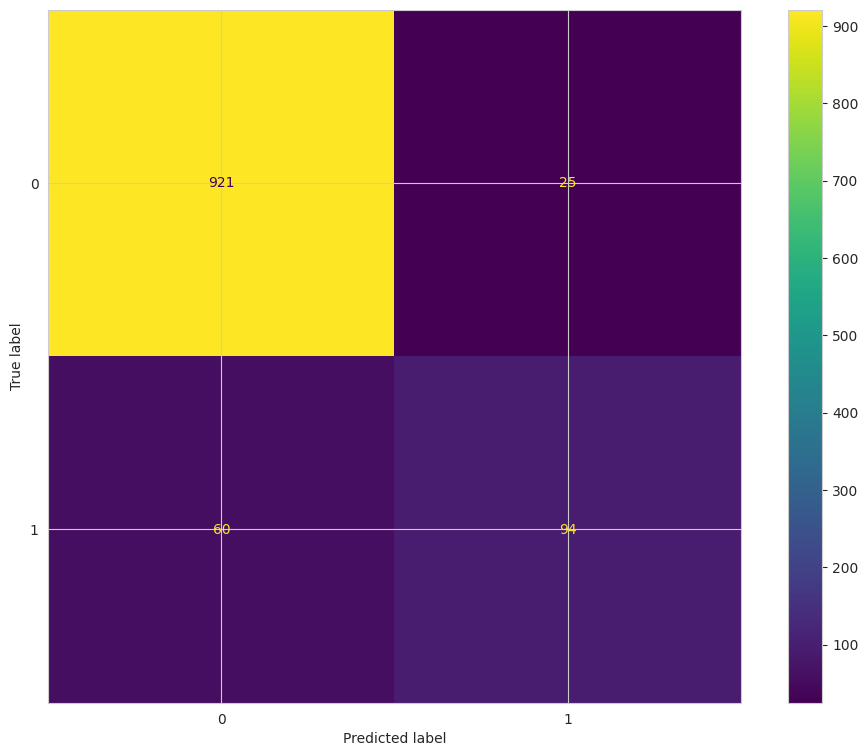

In [130]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot();

2. LGBM random forest

In [143]:
lgbm = lightgbm.LGBMClassifier(random_state=SEED, objective='binary', n_jobs=-1, 
                               boosting_type="rf", scale_pos_weight=5, bagging_freq=1)
lgbm_pipe = Pipeline([('OHE', prepoccessor), ('model', lgbm)])

lgbm_grid = {
    'model__max_depth': [1, 5, 50, -1],
    'model__n_estimators':[1, 10 ,100],
    'model__learning_rate': np.linspace(0.01,0.5,5),
    'model__num_leaves': range(31, 200, 40),
    'model__reg_alpha': [0, 0.2, 1],
    'model__reg_lambda': [0, 0.2, 1],
    'model__bagging_fraction': [0.5, 0.7, 0.9]
    }

gs_lgbm_pipe = GridSearchCV(lgbm_pipe, param_grid=lgbm_grid, cv=cv)
gs_lgbm_pipe.fit(X_train, y_train)
print(gs_lgbm_pipe.best_estimator_)

y_pred = gs_lgbm_pipe.predict(X_test)

print('--------------------------------------')
cross_val_score(estimator=xgb_pipe, X=X_train, y=y_train, cv=3, scoring="f1").mean()
print(f'f1: {f1_score(y_test, y_pred)}, accuracy: {accuracy_score(y_test, y_pred)}')

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9,

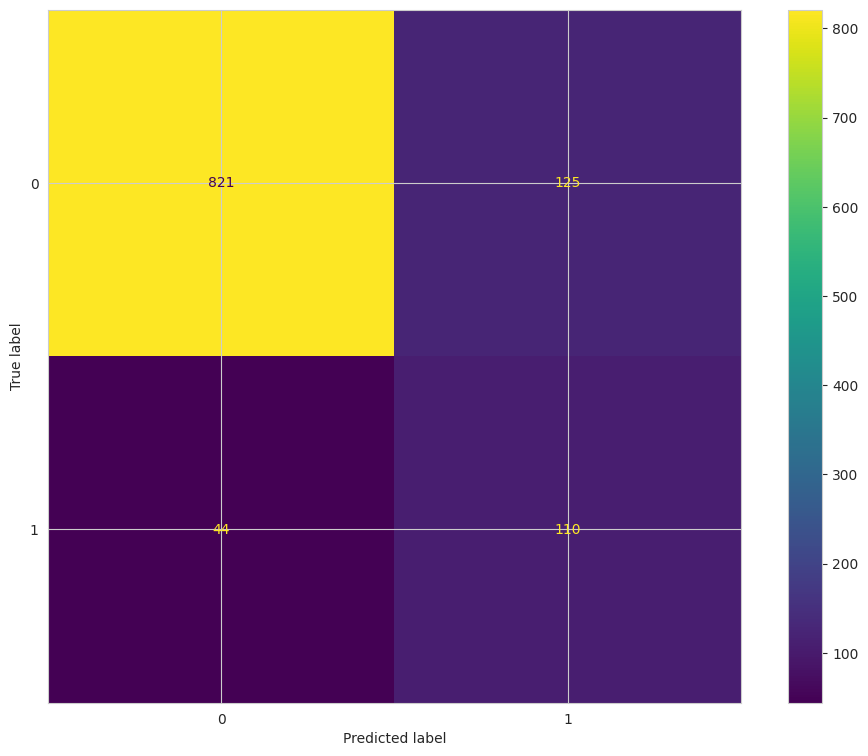

In [144]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot();

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

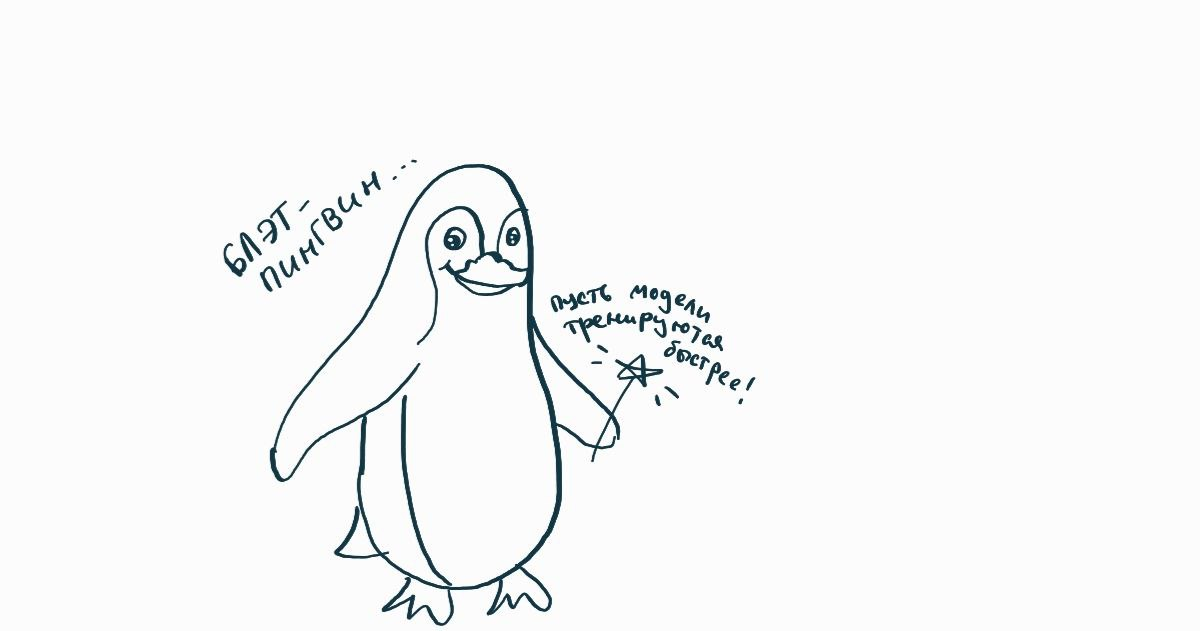

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**